# Credit Card Fraud Detection Problem

## 1) Preparation

In [1]:
# Load libraries
import numpy
from matplotlib import pyplot
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import set_option
from collections import Counter
from termcolor import colored as cl # text customization
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer


from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [ ]:
# Load data
df = pd.read_csv('creditcard.csv')

# drop the Time axis
df.drop('Time', axis=1, inplace=True)

## 2) Data Inspection

In [4]:
#head
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
# size of the dataframe
df.shape

(284807, 30)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

Class
0    284315
1       492
dtype: int64


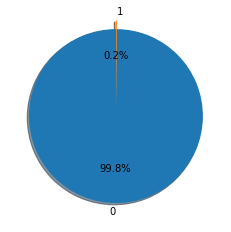

In [10]:
# Class values breakdown
sizes = [df.Class[df['Class']==0].count(), df.Class[df['Class']==1].count()]
pyplot.pie(sizes, explode = (0, 0.1), labels=(0,1), autopct='%1.1f%%', shadow=True, startangle=90)
print(df.groupby('Class').size())

This is a case of highly imbalanced data. There's less than 0.2% of positive minority classes. We have to apply different techniques and metrics to work on this kind of imbalanced data. Conventionally we use accuracy for balanced classification purpose, but accuracy won't work for imbalanced data as for example in this case even if all the negative cases are correctly predicted, the accuracy of the model would be more than 99.8 %, and still it can manage to miss all the positive cases.

Also we cannot use ROC AUC for our problem, since postive cases are more important than negative. The empasis should be given that the model correctly determines the FRAUD cases always. 

We will use F2 score and PR AUC to assess our models. More explanation about theses metrics are given in the note below:

### F-measure and F2 Score

<div class="alert alert-block alert-info">
    
We are interested in the F-measure that will summarize a model's ability
to minimize misclassification errors for the positive class, but we want to favor models that are
better at minimizing false negatives over false positives. This can be achieved by using a version
of the F-measure that calculates a weighted harmonic mean of precision and recall but favors
higher recall scores over precision scores. This is called the Fbeta-measure, a generalization of
F-measure, where beta is a parameter that defines the weighting of the two scores. A beta value
of 2 will weight more attention on recall than precision and is referred to as the F2-measure.

$$ F\beta = \frac{(1 + \beta^2)\times Precision\times Recall}{\beta^2\times Precision + Recall} $$

$$ F2-measure =\frac{(1 + 2^2)\times Precision\times Recall}{2^2\times Precision + Recall} $$


- F0.5-measure (\beta = 0.5): More weight on precision, less weight on recall.
- F1-measure (\beta = 1): Balance the weight on precision and recall.
- F2-measure (\beta = 2): Less weight on precision, more weight on recall.
    
Like precision and recall, a poor F-measure score is 0.0 and a best or perfect F-measure score is 1.0.  
    
</div>

### Precision-Recall Curves and PR AUC Score

<div class="alert alert-block alert-info">

Precision is a metric that quantifies the number of correct positive predictions made. It is
calculated as the number of true positives divided by the total number of true positives and
false positives.

$$ Precision = \frac{True Positive}{True Positive + False Positive} $$


The result is a value between 0.0 for no precision and 1.0 for full or perfect precision. Recall
is a metric that quantifies the number of correct positive predictions made out of all positive
predictions. It is calculated as the number of true positives divided by the total number of true
positives and false negatives (e.g. it is the true positive rate).

$$ Recall = \frac{True Positive}{True Positive + False Negative} $$

The result is a value between 0.0 for no recall and 1.0 for full or perfect recall. Both the
precision and the recall are focused on the positive class (the minority class) and are unconcerned
with the true negatives (majority class).

A precision-recall curve (or PR Curve) is a plot of the precision (y-axis) and the recall
(x-axis) for different probability thresholds.

A model with perfect skill is depicted as a point at a coordinate of (1,1).
A no-skill classifier will be
a horizontal line on the plot with a precision that is proportional to the number of positive
examples in the dataset.

Precision-recall curves (PR curves) are recommended for highly skewed domains
where ROC curves may provide an excessively optimistic view of the performance.

The Precision-Recall AUC is just like the ROC AUC, in that it summarizes the curve with a
range of threshold values as a single score. The score can then be used as a point of comparison
between different models on a binary classification problem where a score of 1.0 represents a
model with perfect skill. The Precision-Recall AUC score can be calculated using the auc()
function in scikit-learn.

To explain why the ROC and PR curves tell a different story, recall that the PR curve
focuses on the minority class, whereas the ROC curve covers both classes. If we use a threshold
of 0.5 and use the logistic regression model to make a prediction for all examples in the test
set, we see that it predicts class 0 or the majority class in all cases. 
    
</div>

In [18]:
# basic statistics
set_option('precision', 3)# 'display.width', 100)
print(df.describe())

              V1         V2         V3         V4         V5         V6         V7         V8  \
count  2.848e+05  2.848e+05  2.848e+05  2.848e+05  2.848e+05  2.848e+05  2.848e+05  2.848e+05   
mean   1.168e-15  3.417e-16 -1.380e-15  2.074e-15  9.604e-16  1.487e-15 -5.556e-16  1.213e-16   
std    1.959e+00  1.651e+00  1.516e+00  1.416e+00  1.380e+00  1.332e+00  1.237e+00  1.194e+00   
min   -5.641e+01 -7.272e+01 -4.833e+01 -5.683e+00 -1.137e+02 -2.616e+01 -4.356e+01 -7.322e+01   
25%   -9.204e-01 -5.985e-01 -8.904e-01 -8.486e-01 -6.916e-01 -7.683e-01 -5.541e-01 -2.086e-01   
50%    1.811e-02  6.549e-02  1.798e-01 -1.985e-02 -5.434e-02 -2.742e-01  4.010e-02  2.236e-02   
75%    1.316e+00  8.037e-01  1.027e+00  7.433e-01  6.119e-01  3.986e-01  5.704e-01  3.273e-01   
max    2.455e+00  2.206e+01  9.383e+00  1.688e+01  3.480e+01  7.330e+01  1.206e+02  2.001e+01   

              V9        V10  ...        V21        V22        V23        V24        V25  \
count  2.848e+05  2.848e+05  ...  2

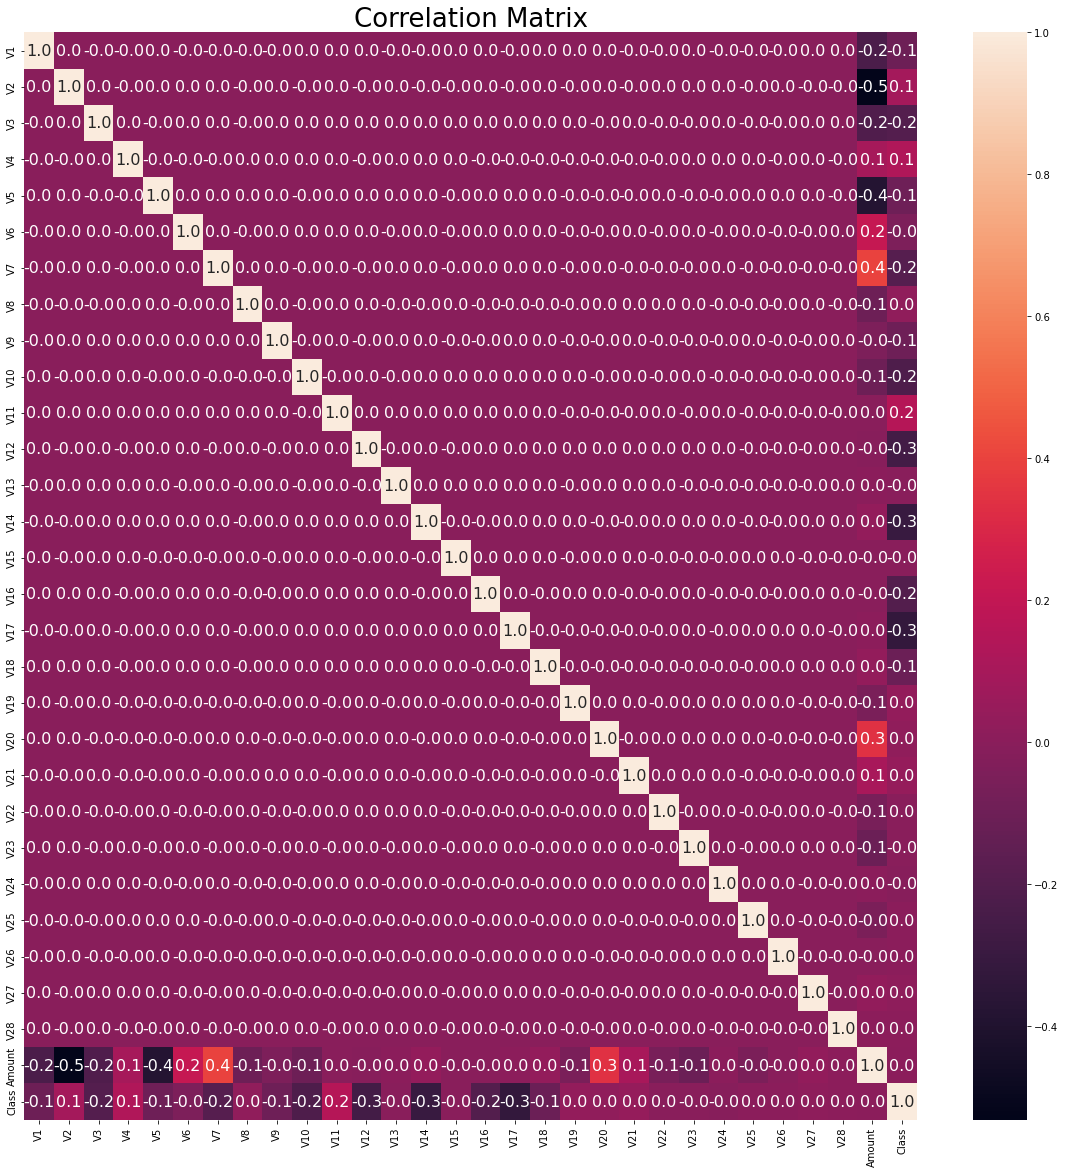

In [6]:
# Correlation Matrix
fig = pyplot.figure(figsize=(20, 20))
ax = sns.heatmap(df.corr(method='pearson'), annot=True,annot_kws={'size':16}, fmt=".1f")
pyplot.title('Correlation Matrix', fontsize=26);

There is not significant correlation observed between different variables. So, we will not worry about Multicollinearity for now.

Our plan is to divide the original data into train and test samples, and run a baseline Dummy Classifier, along with other algorithms. And since the original data is highly imbalanced (0.17% is minority class), we will over/undersample the orignal data using SMOTEENN.

<div class="alert alert-block alert-info">

### SMOTE (Synthetic Minority Oversampling Technique)

SMOTE is the most widely used approach to synthesizing new examples. This technique was described by
Nitesh Chawla, et al. in their 2002 paper named for the technique titled SMOTE: *Synthetic
Minority Over-sampling Technique*. SMOTE works by selecting examples that are close in the
feature space, drawing a line between the examples in the feature space and drawing a new
sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest
neighbors for that example are found (typically k = 5). A randomly selected neighbor is chosen
and a synthetic example is created at a randomly selected point between the two examples in
feature space.

This procedure can be used to create as many synthetic examples for the minority class as
are required. As described in the paper, it suggests first using random undersampling to trim
the number of examples in the majority class, then use SMOTE to oversample the minority
class to balance the class distribution.


### Edited Neartest Neighbors Undersampling

Another rule for finding ambiguous and noisy examples in a dataset is called Edited Nearest
Neighbors, or sometimes ENN for short. This rule involves using k = 3 nearest neighbors to
locate those examples in a dataset that are misclassified and that are then removed before a
k = 1 classification rule is applied. This approach of sampling and classification was proposed
by Dennis Wilson in his 1972 paper titled *Asymptotic Properties of Nearest Neighbor Rules
Using Edited Data*.

When used as an undersampling procedure, the rule can be applied to each example in the
majority class, allowing those examples that are misclassified as belonging to the minority class
to be removed, and those correctly classified to remain. It is also applied to each example in the
minority class where those examples that are misclassified have their nearest neighbors from the
majority class deleted.


### SMOTEENN

Combination of SMOTE (Oversampling) +  Edited Nearest Neighbors Undersampling.

</div>

In [3]:
# Original data
data = df.values
X, y = data[:, :-1].astype('float32'), data[:, -1]

# ordinal encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
print('Original training dataset shape %s' % Counter(y_train))

#Using SMOTEENN sampling technique
sme = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
X_train_smoteenn, y_train_smoteenn = sme.fit_resample(X_train, y_train)
print('Resampled training dataset shape %s' % Counter(y_train_smoteenn))


Original training dataset shape Counter({0: 227453, 1: 392})
Resampled training dataset shape Counter({1: 227453, 0: 226655})


## 3) Base Models

## 3a) Baseline Model Using DummyClassifier

In [7]:
# test harness and baseline model evaluation 

# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation metric
    metric = make_scorer(f2_measure)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (mean(scores), std(scores)))


Mean F2: 0.009 (0.000)


The baseline DummyClassifier algorithm achieves an F2-measure of about 0.009. This score provides a lower limit
on model skill; any model that achieves an average F2-measure above about 0.009 has skill,
whereas models that achieve a score below this value do not have skill on this dataset.

## 3b) Evaluating Some Baseline Models 

>LR 0.585 (0.055)
>LDA 0.783 (0.057)
>SVM 0.806 (0.051)
>KNN 0.812 (0.047)
>RF 0.817 (0.049)
>XGB 0.823 (0.044)


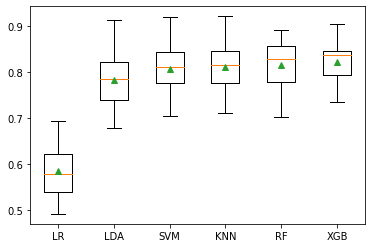

In [127]:
# spot check machine learning algorithms 

# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    # Random Forest
    models.append(RandomForestClassifier())
    names.append('RF')
    # XGB
    models.append(XGBClassifier())
    names.append('XGB')
    return models, names

# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # create a pipeline
    steps = [('t1', MinMaxScaler()),('m',models[i])]
    pipeline = Pipeline(steps=steps)
    # evaluate the model and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


Looks like XGB is the best one and LR is the worst one. Let's run the above alogorithms again on the new resampled data using SMOTEENN. We will compare their F2 Scores, Confusion Matrices, Classification Reports, ROC AUC, and PR AUC.

## 4) SMOTEENN with Models

Let's define some functions which will be used repetitively for different models

In [8]:
# Collection of functions

# prepare the model
def prepare_model(X_train_smoteenn, y_train_smoteenn, X_test, ML_model):
    scaler = MinMaxScaler().fit(X_train_smoteenn)
    rescaledX = scaler.transform(X_train_smoteenn)
    model = ML_model 
    model.fit(rescaledX, y_train_smoteenn)
    # estimate metrics on validation dataset
    rescaledX_test= scaler.transform(X_test)
    yhat = model.predict(rescaledX_test)
    return rescaledX_test, yhat
#rescaledX_test, yhat = prepare_model(X_train_smoteenn, y_train_smoteenn, X_test, ML_model)

# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Confusion Matrix
def plot_confusion_matrix(y_test, yhat):
    print(cl('CONFUSION MATRIX', attrs = ['bold']))
    cm = confusion_matrix(y_test, yhat)
    ax= pyplot.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax); 
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix');
    pyplot.show()

# Classification Report
def create_classification_report(y_test, yhat):
    print(cl('CLASSIFICATION REPORT', attrs = ['bold']))
    print(classification_report(y_test, yhat), end = '\n\n')

# F2 Measure
def print_F2(y_test, yhat):
    print(cl('F2_MEASURE: %.3f',attrs = ['bold'] ) % f2_measure(y_test, yhat), end = '\n\n')

# ROC Score    
def print_roc_score(y_test, yhat):
    print(cl('ROC AUC SCORE: %.3f',attrs = ['bold'])  %roc_auc_score(y_test, yhat))

# Calculatre probabilities
def find_probability(model, rescaledX_test):
    # predict probabilities
    probs = model.predict_proba(rescaledX_test)
    # keep probabilities for the positive outcome only
    probs1 = probs[:, 1]
    return probs1


# ROC Curve
def plot_roc_curve(probs1, model_name):
    # calculate roc curve for model
    fpr, tpr, thresholds = roc_curve(y_test, probs1)
    # plot no skill roc curve
    pyplot.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
    # plot model roc curve
    pyplot.plot(fpr, tpr, marker = '*' , label = model_name)
    # axis labels
    pyplot.title('ROC CURVE')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
#PR Score    
def print_PR_Score(probs1):
    precision, recall, _ = precision_recall_curve(y_test, probs1)
    auc_score = auc(recall, precision)
    print(cl('PR AUC SCORE: %.3f',attrs = ['bold']) % auc_score)
    return precision, recall



# PR Curve    
def PR_AUC_plot(precision, recall, model_name):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y[y==1]) / len(y)
    # plot the no skill precision-recall curve
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the model precision-recall curve
    pyplot.plot(recall, precision, marker='.', label=model_name)
    # axis labels
    pyplot.title('PR CURVE')
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

## 4a) Logistic Regression 

F2_MEASURE: 0.312

CONFUSION MATRIX


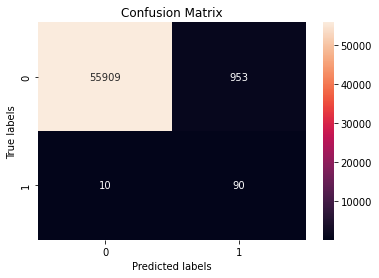

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56862
           1       0.09      0.90      0.16       100

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962


ROC AUC SCORE: 0.942


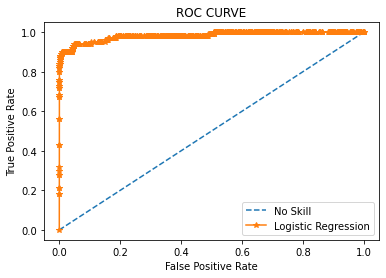

PR AUC SCORE: 0.773


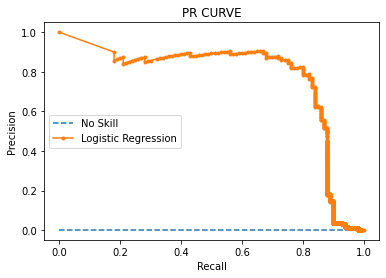

In [9]:
modelName = LogisticRegression(solver='liblinear')
model_name = 'Logistic Regression'

# prepare the model
rescaledX_test, yhat = prepare_model(X_train_smoteenn, y_train_smoteenn, X_test, modelName)

# F2 Measure
print_F2(y_test, yhat)

# Confusion Matrix
plot_confusion_matrix(y_test, yhat)


# Classification Report
create_classification_report(y_test, yhat)

# ROC AUC Score
print_roc_score(y_test, yhat)

# ROC Curve
probs1 = find_probability(modelName, rescaledX_test)
plot_roc_curve(probs1, model_name)

# PR AUC Score
precision, recall = print_PR_Score(probs1)

# PR Curve    
PR_AUC_plot(precision, recall, model_name)

The F2 (0.312) scores seems to be worse than the one from original data (0.585). But again we are not very sure of this number as we did not run cross-validation (CV) as before (to be sure the numbers we are getting is just a pure statistical fluke). It was computationally expensive to run Cross-validation, so we just stick to run other models on test-train samples only. 

## 4b) LDA

F2_MEASURE: 0.316

CONFUSION MATRIX


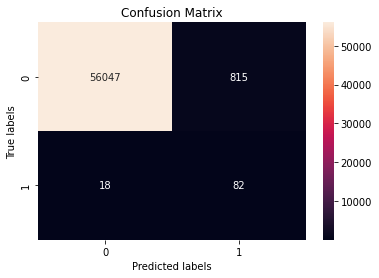

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56862
           1       0.09      0.82      0.16       100

    accuracy                           0.99     56962
   macro avg       0.55      0.90      0.58     56962
weighted avg       1.00      0.99      0.99     56962


ROC AUC SCORE: 0.903


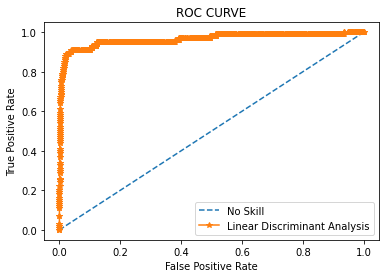

PR AUC SCORE: 0.237


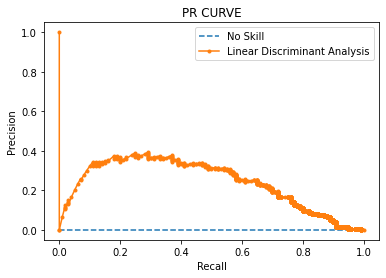

In [10]:
modelName = LinearDiscriminantAnalysis()
model_name = 'Linear Discriminant Analysis'

# prepare the model
rescaledX_test, yhat = prepare_model(X_train_smoteenn, y_train_smoteenn, X_test, modelName)

# F2 Measure
print_F2(y_test, yhat)

# Confusion Matrix
plot_confusion_matrix(y_test, yhat)


# Classification Report
create_classification_report(y_test, yhat)

# ROC AUC Score
print_roc_score(y_test, yhat)

# ROC Curve
probs1 = find_probability(modelName, rescaledX_test)
plot_roc_curve(probs1, model_name)

# PR AUC Score
precision, recall = print_PR_Score(probs1)

# PR Curve    
PR_AUC_plot(precision, recall, model_name)

The F2 score is improved compared to the logistic Regression, but PR AUC Score seems to get worse here for LDA.

## 4c) KNeighborsClassifier

F2_MEASURE: 0.753

CONFUSION MATRIX


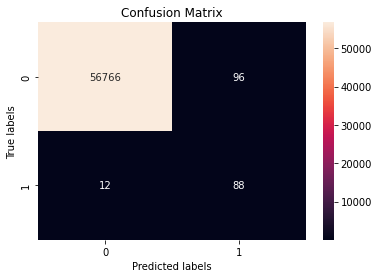

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.48      0.88      0.62       100

    accuracy                           1.00     56962
   macro avg       0.74      0.94      0.81     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC SCORE: 0.939


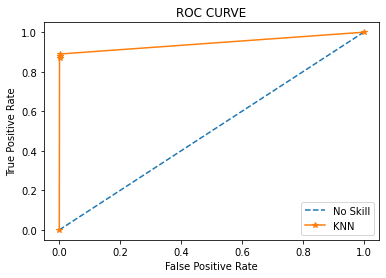

PR AUC SCORE: 0.753


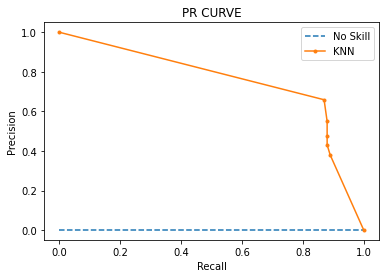

In [11]:
modelName = KNeighborsClassifier()
model_name = 'KNN'

# prepare the model
rescaledX_test, yhat = prepare_model(X_train_smoteenn, y_train_smoteenn, X_test, modelName)

# F2 Measure
print_F2(y_test, yhat)

# Confusion Matrix
plot_confusion_matrix(y_test, yhat)


# Classification Report
create_classification_report(y_test, yhat)

# ROC AUC Score
print_roc_score(y_test, yhat)

# ROC Curve
probs1 = find_probability(modelName, rescaledX_test)
plot_roc_curve(probs1, model_name)

# PR AUC Score
precision, recall = print_PR_Score(probs1)

# PR Curve    
PR_AUC_plot(precision, recall, model_name)

So far KNN has better F2 score of 0.753, compared to two previous models. Let's run Random Forest Classifier.

## 4d) RandomForestClassifier

F2_MEASURE: 0.855

CONFUSION MATRIX


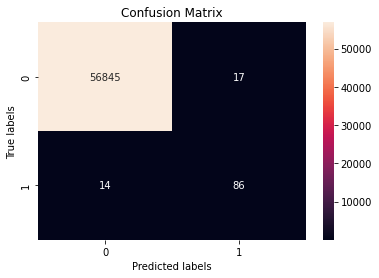

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.83      0.86      0.85       100

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC SCORE: 0.930


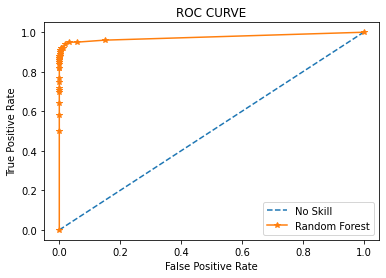

PR AUC SCORE: 0.873


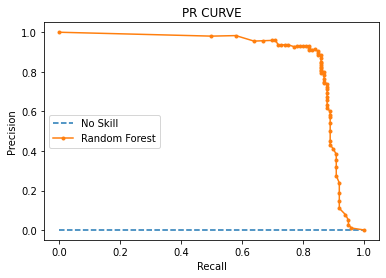

In [12]:
modelName = RandomForestClassifier()
model_name = 'Random Forest'

# prepare the model
rescaledX_test, yhat = prepare_model(X_train_smoteenn, y_train_smoteenn, X_test, modelName)

# F2 Measure
print_F2(y_test, yhat)

# Confusion Matrix
plot_confusion_matrix(y_test, yhat)


# Classification Report
create_classification_report(y_test, yhat)

# ROC AUC Score
print_roc_score(y_test, yhat)

# ROC Curve
probs1 = find_probability(modelName, rescaledX_test)
plot_roc_curve(probs1, model_name)

# PR AUC Score
precision, recall = print_PR_Score(probs1)

# PR Curve    
PR_AUC_plot(precision, recall, model_name)

The F2 score is 0.855, and PR AUC Score is 0.873. Let's run our last model which is XGBoost Classifier.

## 4d) XGBClassifier

F2_MEASURE: 0.849

CONFUSION MATRIX


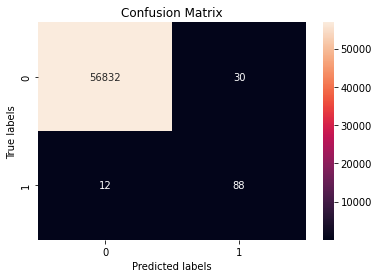

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.75      0.88      0.81       100

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC SCORE: 0.940


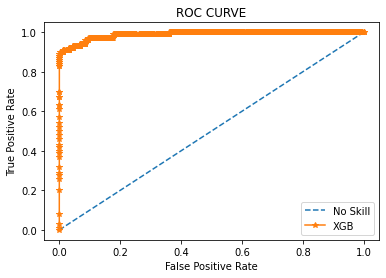

PR AUC SCORE: 0.875


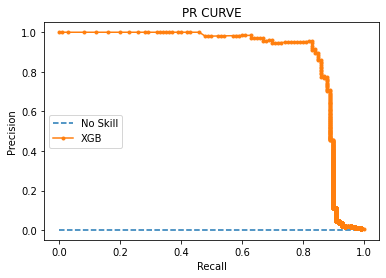

In [13]:
modelName = XGBClassifier()
model_name = 'XGB'

# prepare the model
rescaledX_test, yhat = prepare_model(X_train_smoteenn, y_train_smoteenn, X_test, modelName)

# F2 Measure
print_F2(y_test, yhat)

# Confusion Matrix
plot_confusion_matrix(y_test, yhat)


# Classification Report
create_classification_report(y_test, yhat)

# ROC AUC Score
print_roc_score(y_test, yhat)

# ROC Curve
probs1 = find_probability(modelName, rescaledX_test)
plot_roc_curve(probs1, model_name)

# PR AUC Score
precision, recall = print_PR_Score(probs1)

# PR Curve    
PR_AUC_plot(precision, recall, model_name)

The F2 Score for XGBClassifier is 0.849, and PR AUC Score is 0.875. So far we can see Random Forest and XGBoost doing better compared to other three models.

## 5) Conclusions

First we used DummyClassifier as a base model, and F2 measure as the metric, we got 0.009. Next we ran CV on the original data using five different models, got F2-scores as : 
- LR  : 0.585
- LDA : 0.783
- SVM : 0.806 
- KNN : 0.812
- RF  : 0.817 
- XGB : 0.823 

Next, we split the under/oversampled data into test-train, and ran the same models (actually SVM was left out due to high computation time). The F2 scores obtained are:
- LR  : 0.312
- LDA : 0.316
- KNN : 0.753
- RF  : 0.855
- XGB : 0.849

We can see that only improvement is observed for RF and XGB. PR AUC Score also shows the promising result from these two models. There's still a load of stuff we can do to improve these numbers. Please refer to the following suggestions for further improvement:

<div class="alert alert-block alert-info">

**SUGGESTIONS**

- Use Cross-Validation instead of simply using a set of test-train split on resampled data (the catch is it is computationally expensive as there are about 285k instances with 30 variables).
- Experiment with other sampling techniques as well.
- Play around with cost-sensitive learning.
- Look into Probabililty threshold moving, Optimal Threshold for ROC and PR Curves.
- Investigate more into probability predicting (probability-like scores). We have to be careful the probabilities obtained from many models (eg SVM, Decision Trees, Ensembles, KNN) are not calibrated (unlike logistic Regression, LDA, NB, ANN). Those models need to be well-calibrated such that the probabilities reflect the true likelihood of the event of interest.
    
</div>